In [1]:
# This code can be downloaded as a Python script and run as:
# python full_vs_EM_any_dataset.py random_state dataset_name test_proportion val_proportion M_method M_alpha M_beta
#     test_proportion: The test proportion is from all the available true labels
#     val_proportion: The validation proportion is from the remaining training proportion with the true labels

def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

import sys

if is_interactive():
    %matplotlib inline
    sys.path.append('../')
    random_state = 0
    dataset_name = 'labelme'
    prop_test = 0.7
    prop_val = 0.5
    M_method = 'noisy' # IPL, quasi_IPL, random_weak, random_noise, noisy, supervisedg
    M_alpha = 0.5 # Alpha = 1.0 No unsupervised in IPL
    M_beta = 0.5 # Beta = 0.0 No noise
    data_folder = '../data/'
else:
    random_state = int(sys.argv[1])
    dataset_name = sys.argv[2]
    prop_test = float(sys.argv[3])
    prop_val = float(sys.argv[4])
    if len(sys.argv) > 5:
        M_method = sys.argv[5]
        M_alpha = float(sys.argv[6])
        if len(sys.argv) > 7:
            M_beta = float(sys.argv[7])
        else:
            M_beta = 1 - M_alpha
    data_folder = './data/'
    print(locals())

import numpy
from experiments.data import make_weak_true_partition
from wlc.WLweakener import computeM, weak_to_index, estimate_M
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from experiments.models import create_model, MyKerasClassifier
import inspect
from keras.callbacks import EarlyStopping

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
from matplotlib import cm

from experiments.visualizations import plot_heatmap
from experiments.visualizations import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams["figure.dpi"] = 100

cmap = cm.get_cmap('Accent')

from cycler import cycler
default_cycler = (cycler(color=['darkred', 'forestgreen', 'darkblue', 'violet', 'darkorange', 'saddlebrown']) +
                  cycler(linestyle=['-', '--', '-.', '-', '--', '-.']) + 
                  cycler(marker=['o', 'v', 'x', '+', '-', '.']) +
                  cycler(lw=[2, 1.8, 1.6, 1.4, 1.2, 1]))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

Using TensorFlow backend.


# 1.a. Load data

The following data may contain weak, true labels or both ($S_w$, $S_t$ and $S_wt$ respectively).

- **PLEASE NOTE**: The current assumption is that the data is originally completly clean, or weak and weak+clean. But there is no current data with weak, weak+clean and clean. If at any point we have an example of that case we will need to rethinkg part of **Section 1**.

In [2]:
numpy.random.seed(random_state)

from sklearn.datasets import make_classification, make_blobs, load_digits
from experiments.data import load_webs, load_labelme
    
n_samples = 2000
n_features = 20
n_classes = 3
true_size = 0.1
classes = list(range(n_classes))
only_weak = ()
weak_and_true = ()
only_true = ()

if dataset_name == 'digits':
    true_size = 0.1
    X_t, y_t = load_digits(return_X_y=True)
    n_classes = 10
    true_size = 0.1
    classes = list(range(n_classes))
    n_samples = X_t.shape[0]
    n_features = X_t.shape[1]
    only_true = (X_t, y_t)
elif dataset_name == 'blobs':
    n_classes = 4
    classes = list(range(n_classes))
    n_samples = 2000
    n_features = 60
    centers = numpy.random.rand(n_classes, n_features)*n_features
    cluster_std = numpy.abs(numpy.random.randn(n_classes)*n_features)
    X_t, y_t = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                      cluster_std=cluster_std, random_state=random_state)
    only_true = (X_t, y_t)
elif dataset_name == 'make_classification':
    n_classes = 12
    classes = list(range(n_classes))
    n_features = 100
    n_samples = 10000
    n_redundant = 0
    n_clusters_per_class = 1
    n_informative = n_features
    X_t, y_t = make_classification(n_samples=n_samples, n_features=n_features,
                               n_classes=n_classes, random_state=random_state,
                               n_redundant=n_redundant,
                               n_informative=n_informative,
                               n_clusters_per_class=n_clusters_per_class)
    only_true = (X_t, y_t)
elif dataset_name == 'separable':
    
    means = [[-1, -1],
             [-1,  1],
             [ 1,  1]]
    n_classes = len(means)
    classes = list(range(n_classes))
    std = .5
    priors = numpy.array([1/3, 1/3, 1/3])
    samples_per_class = (n_samples*priors).astype(int)
    X_t, y_t = make_blobs(n_samples=samples_per_class, n_features=n_features, centers=means,
                      cluster_std=std, random_state=random_state)
    only_true = (X_t, y_t)
    n_samples = X_t.shape[0]
    n_features = X_t.shape[1]
elif dataset_name == 'non_separable':
    std = 2.0
    n_features = 5
    X_t, y_t =  make_blobs(n_samples=n_samples, n_features=n_features, centers=12,
                           cluster_std=std, random_state=random_state)
    y_t[y_t < 5] = 0
    y_t[y_t > 7] = 1
    y_t[y_t > 1] = 2
    only_true = (X_t, y_t)
    n_classes = 3
    n_samples = X_t.shape[0]
    n_features = X_t.shape[1]
elif dataset_name == 'webs':
    only_weak, weak_and_true, only_true, classes = load_webs(tfidf=True, standardize=True,
                                                categories=['blog', 'inmo', 'parking', 'b2c', 'no_b2c', 'Other'],
                                                random_state=random_state,
                                                folder=data_folder)
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
    n_samples = X_wt.shape[0] + X_w.shape[0]
elif dataset_name == 'labelme':
    only_weak, weak_and_true, only_true, classes = load_labelme(
                                                random_state=random_state,
                                                folder=data_folder,
                                                keep_valid_test=False,
                                                prop_test=prop_test)
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    X_t, Y_t, y_t = only_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
    n_samples = X_wt.shape[0] + X_w.shape[0] + X_t.shape[0]
else:
    raise KeyError('Dataset {} not available'.format(dataset_name))

print('Number of features = {}'.format(n_features))
print('Number of classes = {}'.format(n_classes))
print('Class names = {}'.format(classes))

n_only_weak = 0 if not only_weak else only_weak[0].shape[0]
n_weak_and_true = 0 if not weak_and_true else weak_and_true[0].shape[0]
n_only_true = 0 if not only_true else only_true[0].shape[0]
print('Samples with only weak labels = {}'.format(n_only_weak))
print('Samples with weak and true labels = {}'.format(n_weak_and_true))
print('Samples with only true labels = {}'.format(n_only_true))

Number of features = 8192
Number of classes = 8
Class names = ['highway', 'insidecity', 'tallbuilding', 'street', 'forest', 'coast', 'mountain', 'opencountry']
Samples with only weak labels = 2710
Samples with weak and true labels = 310
Samples with only true labels = 6980


# 1.b. Create synthetic weak labels if required

If the dataset does not have weak labels we will generate a random mixing matrix and generate weak labels for some of the samples.

In [3]:
if not only_weak and not weak_and_true:
    if M_method != 'IPL':
        M_alpha = 1.0

    M = computeM(n_classes, method=M_method, alpha=M_alpha, beta=M_beta,
                 seed=random_state)

    print(numpy.round(M, decimals=3))
    
    only_weak, weak_and_true, only_true, classes = make_weak_true_partition(M, X_t, y_t,
                                                                            true_size=true_size,
                                                                            random_state=random_state)

    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
else:
    M_method = None
    M_alpha = None
    M_beta = None
    M = estimate_M(Z_wt, Y_wt, range(n_classes), reg='Partial', Z_reg=Z_w)

n_w_samples = 0 if not only_weak else only_weak[0].shape[0]
n_wt_samples = 0 if not weak_and_true else weak_and_true[0].shape[0]
n_t_samples = 0 if not only_true else only_true[0].shape[0]
print('Samples with only weak labels = {}'.format(n_w_samples))
print('Samples with weak and true labels = {}'.format(n_wt_samples))
print('Samples with only true labels = {}'.format(n_t_samples))

print(Y_wt.mean(axis=0))

Samples with only weak labels = 2710
Samples with weak and true labels = 310
Samples with only true labels = 6980
[0.12903226 0.12903226 0.09677419 0.09677419 0.12903226 0.16129032
 0.12903226 0.12903226]


../wlc/WLweakener.py:496: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = alpha


# 1.c. Show weak and true samples

In the following plots we show only the 2 features with most variance on every set

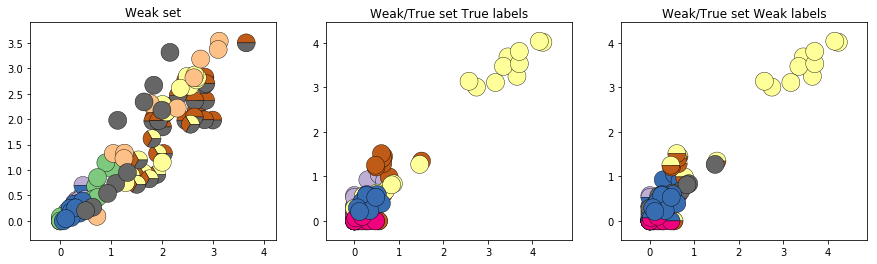

In [4]:
from experiments.visualizations import plot_multilabel_scatter

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
_ = plot_multilabel_scatter(X_w[:100, ], Z_w[:100], fig=fig,
                            ax=ax, title='Weak set', cmap=cmap)
ax = fig.add_subplot(1, 3, 2)
_ = plot_multilabel_scatter(X_wt[:100], Y_wt[:100], fig=fig,
                            ax=ax, title='Weak/True set True labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 3)
_ = plot_multilabel_scatter(X_wt[:100], Z_wt[:100], fig=fig,
                            ax=ax, title='Weak/True set Weak labels', cmap=cmap)

# 1.d. Save true labels for validation and for testing

If there is a set with only true labels, it is ussed always as a test set only (not validation)

In [ ]:
# prop_test is defined in the arguments

sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state,
                             train_size=(1. - prop_test),
                             test_size=prop_test)

train_indx, test_indx = next(sss.split(X_wt, y_wt))
n_wt_samples = len(z_wt)
print('Weak and true labels: Original partition size = {}'.format(n_wt_samples))

# train partition
X_wt_train, Z_wt_train, z_wt_train = X_wt[train_indx], Z_wt[train_indx], z_wt[train_indx]
Y_wt_train, y_wt_train = Y_wt[train_indx], y_wt[train_indx]
# test partition
X_wt_test, Z_wt_test, z_test = X_wt[test_indx], Z_wt[test_indx], z_wt[test_indx]
Y_wt_test, y_wt_test = Y_wt[test_indx], y_wt[test_indx]

if n_only_true != 0:
    X_wt_test = numpy.concatenate((X_wt_test, X_t))
    Y_wt_test = numpy.concatenate((Y_wt_test, Y_t))
    y_wt_test = numpy.concatenate((y_wt_test, y_t))


# We will use half of the train data for validation
sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state,
                             train_size=(1. - prop_val),
                             test_size=prop_val)

train_indx, val_indx = next(sss.split(X_wt_train, y_wt_train))
# Validation partition
X_wt_val, Z_wt_val, z_wt_val = X_wt_train[val_indx], Z_wt_train[val_indx], z_wt_train[val_indx]
Y_wt_val, y_wt_val = Y_wt_train[val_indx], y_wt_train[val_indx]
# train partition
X_wt_train, Z_wt_train, z_wt_train = X_wt_train[train_indx], Z_wt_train[train_indx], z_wt_train[train_indx]
Y_wt_train, y_wt_train = Y_wt_train[train_indx], y_wt_train[train_indx]


n_wt_samples_train = len(y_wt_train)
n_wt_samples_val = len(y_wt_val)
n_wt_samples_test = len(y_wt_test)
print('Weak and true labels for training partition size = {}'.format(n_wt_samples_train))
print('True labels for validation partition size = {}'.format(n_wt_samples_val))
print('True labels for test partition size = {}'.format(n_wt_samples_test))

Weak and true labels: Original partition size = 310
Weak and true labels for training partition size = 46
True labels for validation partition size = 47
True labels for test partition size = 7197


# 2.a. Train Scikit learn baselines

## 2.a.1. Upperbound if we have access to the full true labels

- This trains with all the following partitions
    - $S_w$
    - $S_{wt.train}$
    - $S_{wt.val}$

A Logistic Regression trained with all the real labels (2803 samples)
Accuracy = 0.8641100458524386


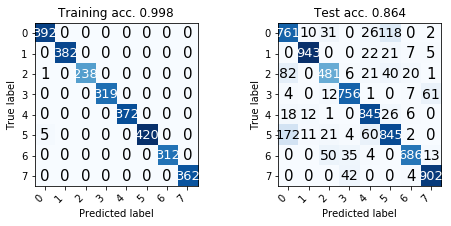

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [ ]:
max_epochs = 2000

if y_w is not None:
    X_aux_train = numpy.concatenate((X_w, X_wt_train, X_wt_val))
    y_aux_train = numpy.concatenate((y_w, y_wt_train, y_wt_val))
    LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs, penalty='l2', C=0.01)
    LR.fit(X_aux_train, y_aux_train)
    print('A Logistic Regression trained with all the real labels ({} samples)'.format(y_aux_train.shape[0]))
    acc_upperbound = LR.score(X_wt_test, y_wt_test)
    print('Accuracy = {}'.format(acc_upperbound))

    fig = plt.figure(figsize=(8,3))
    clf_pred =  LR.predict(X_aux_train)
    cm = confusion_matrix(y_aux_train, clf_pred)
    acc = (y_aux_train == clf_pred).mean()
    ax = fig.add_subplot(1, 2, 1)
    _ = plot_confusion_matrix(cm, ax=ax, title='Training acc. {:.3}'.format(acc))

    clf_pred =  LR.predict(X_wt_test)
    cm = confusion_matrix(y_wt_test, clf_pred)
    acc = (y_wt_test == clf_pred).mean()
    ax = fig.add_subplot(1, 2, 2)
    _ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

## 2.a.2. Lowerbound if we have access to a limited set of true labels


- This trains with all the following partitions
    - $S_{wt.train}$
    - $S_{wt.val}$

A Logistic Regression trained with all the real labels (93 samples)
Accuracy = 0.6477699041267194


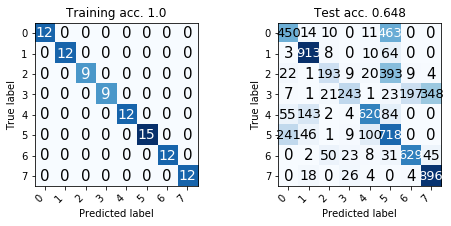

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [ ]:
max_epochs = 2000

X_aux_train = numpy.concatenate((X_wt_train, X_wt_val))
y_aux_train = numpy.concatenate((y_wt_train, y_wt_val))
LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs, penalty='l2', C=0.01)
LR.fit(X_aux_train, y_aux_train)
print('A Logistic Regression trained with all the real labels ({} samples)'.format(y_aux_train.shape[0]))
acc_upperbound = LR.score(X_wt_test, y_wt_test)
print('Accuracy = {}'.format(acc_upperbound))

fig = plt.figure(figsize=(8,3))
clf_pred =  LR.predict(X_aux_train)
cm = confusion_matrix(y_aux_train, clf_pred)
acc = (y_aux_train == clf_pred).mean()
ax = fig.add_subplot(1, 2, 1)
_ = plot_confusion_matrix(cm, ax=ax, title='Training acc. {:.3}'.format(acc))

clf_pred =  LR.predict(X_wt_test)
cm = confusion_matrix(y_wt_test, clf_pred)
acc = (y_wt_test == clf_pred).mean()
ax = fig.add_subplot(1, 2, 2)
_ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

# 2.b. Train Keras baselines

**TODO: check what happens when there is a typo on the early_stop_loss**


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras import regularizers

_EPSILON = K.epsilon()

def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -y_true*K.log(y_pred)
    return K.mean(out, axis=-1)

def make_model(loss):
    model = Sequential() 
    model.add(Dense(n_classes, input_dim=n_features, activation='softmax',
                bias_initializer='zeros', 
                kernel_regularizer=regularizers.l2(1.0),
                kernel_initializer='glorot_normal'))
    model.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy', 'mean_squared_error',
                           'categorical_crossentropy'])
    print('Sample of first weights = {}'.format(numpy.round(model.get_weights()[0][0], decimals=3)))
    return model

from keras.callbacks import EarlyStopping

batch_size = 1024
patience = 500
early_stop_loss = 'val_categorical_crossentropy' # TODO Check what happens when there is a typo in this loss

early_stopping = EarlyStopping(monitor=early_stop_loss, min_delta=0, patience=patience, 
                               verbose=0, mode='auto', baseline=None,
                               restore_best_weights=True)

def plot_results(model, X_test, y_test, history):
    clf_proba_wt_test = model.predict_proba(X_test)
    clf_pred_wt_test = numpy.argmax(clf_proba_wt_test, axis=1)
    cm = confusion_matrix(y_test, clf_pred_wt_test)

    fig = plt.figure(figsize=(16, 3))
    n_fig = 5
    ax = fig.add_subplot(1, n_fig, 1)
    _ = ax.plot(history.history['loss'], label='Training loss')
    _ = ax.plot(history.history['val_loss'], label='Validation loss')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 2)
    _ = ax.plot(history.history['categorical_crossentropy'], label='Training CE')
    _ = ax.plot(history.history['val_categorical_crossentropy'], label='Validation CE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 3)
    _ = ax.plot(history.history['mean_squared_error'], label='Training MSE')
    _ = ax.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 4)
    _ = ax.plot(history.history['acc'], label='Training acc')
    _ = ax.plot(history.history['val_acc'], label='Validation acc')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 5)
    acc = (y_test == clf_pred_wt_test).mean()
    _ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))
    
    if not is_interactive():
        plt.close(fig)

## 2.b.2. Upperbound if multiple true labels are available

Sample of first weights = [ 0.02  -0.014  0.006 -0.006 -0.022  0.003 -0.03   0.014]
A Keras Logistic Regression trained with all the real labels (93 samples)
Accuracy = 0.6905655134083646


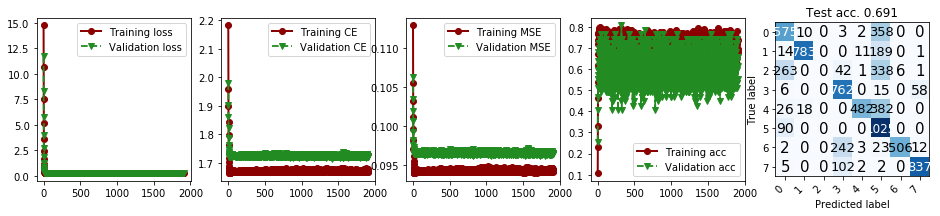

<Figure size 360x288 with 0 Axes>

In [ ]:
if y_w is not None:
    numpy.random.seed(random_state)
    model = make_model(log_loss)

    X_aux_train = numpy.concatenate((X_w, X_wt_train))
    Y_aux_train = numpy.concatenate((Y_w, Y_wt_train))
    history = model.fit(X_aux_train, Y_aux_train, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)

    plot_results(model, X_wt_test, y_wt_test, history)

    print('A Keras Logistic Regression trained with all the real labels ({} samples)'.format(y_aux_train.shape[0]))
    acc_upperbound = (model.predict_proba(X_wt_test).argmax(axis=1) == y_wt_test).mean()
    print('Accuracy = {}'.format(acc_upperbound))
else:
    acc_upperbound = None

## 2.b.2. Lowerbound with a small amount of true labels

Sample of first weights = [ 0.02  -0.014  0.006 -0.006 -0.022  0.003 -0.03   0.014]
Sample of train labels = [[0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0]]
Sample of validation labels = [[0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]
A Keras Logistic Regression trained with only training true labels (46 samples)
Accuracy = 0.5580102820619702


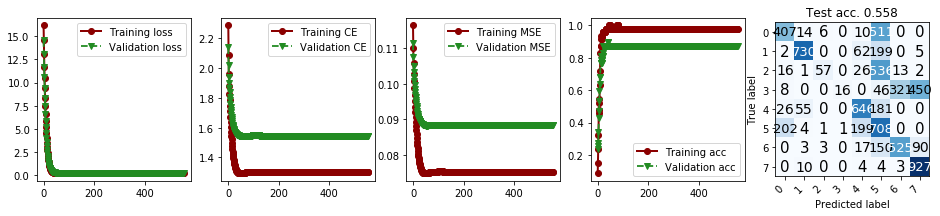

<Figure size 360x288 with 0 Axes>

In [ ]:
numpy.random.seed(random_state)
model = make_model(log_loss)

print('Sample of train labels = {}'.format(numpy.round(Y_wt_train[:2], decimals=2)))
print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
history = model.fit(X_wt_train, Y_wt_train, 
                    validation_data=(X_wt_val, Y_wt_val),
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size, shuffle=True)

plot_results(model, X_wt_test, y_wt_test, history)

print('A Keras Logistic Regression trained with only training true labels ({} samples)'.format(Y_wt_train.shape[0]))
acc_lowerbound = (model.predict_proba(X_wt_test).argmax(axis=1) == y_wt_test).mean()
print('Accuracy = {}'.format(acc_lowerbound))

## 2.b.3. Training directly with different proportions of weak labels

In [ ]:
list_weak_proportions = numpy.array([0.0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 0.7, 1.0])
acc = {}

In [ ]:
method = 'Weak'
acc[method] = numpy.zeros_like(list_weak_proportions)
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*X_w.shape[0])
    
    
    X_aux_train = numpy.concatenate((X_w[:last_index], X_wt_train))
    Z_aux_train = numpy.concatenate((Z_w[:last_index], Y_wt_train))
    
    numpy.random.seed(random_state)
    model = make_model(log_loss)

    print('Sample of train labels = {}'.format(numpy.round(Z_aux_train[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    history = model.fit(X_aux_train, Z_aux_train,
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} from total {}, Accuracy = {:.3f}'.format(last_index, Z_aux_train.shape[0], acc[method][i]))
    
    plot_results(model, X_wt_test, y_wt_test, history)

Sample of first weights = [ 0.02  -0.014  0.006 -0.006 -0.022  0.003 -0.03   0.014]
Sample of train labels = [[0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0]]
Sample of validation labels = [[0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]
Number of weak samples = 0 from total 46, Accuracy = 0.558
Sample of first weights = [ 0.02  -0.014  0.006 -0.006 -0.022  0.003 -0.03   0.014]
Sample of train labels = [[0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 1]]
Sample of validation labels = [[0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]
Number of weak samples = 2 from total 48, Accuracy = 0.563
Sample of first weights = [ 0.02  -0.014  0.006 -0.006 -0.022  0.003 -0.03   0.014]
Sample of train labels = [[0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 1]]
Sample of validation labels = [[0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]


# 3. Train EM

## 3.a. Learning mixing matrix M

In [ ]:
categories = range(n_classes)
from wlc.WLweakener import newWeakCount
w_count = newWeakCount(Z_wt_train, Y_wt_train, range(n_classes), reg='Partial', Z_reg=Z_w).astype(int)
print("Weak count\n{}".format(w_count.todense()))
# 1.a. Learn a mixing matrix using training with weak and true labels
M_0 = estimate_M(Z_wt_train, Y_wt_train, range(n_classes), reg='Partial', Z_reg=Z_w)
M_1 = computeM(c=n_classes, method='supervised')
q_0 = X_w.shape[0] / float(X_w.shape[0] + X_wt_train.shape[0])
q_1 = X_wt_train.shape[0] / float(X_w.shape[0] + X_wt_train.shape[0])
M_EM = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)

print('q0 = {}, q1 = {}'.format(q_0, q_1))
print("M_0 shape = {}\n{}".format(M_0.shape, numpy.round(M_0, decimals=3)))
print("M_1 shape = {}\n{}".format(M_1.shape, numpy.round(M_1, decimals=3)))
print("M_EM shape = {}\n{}".format(M_EM.shape, numpy.round(M_EM, decimals=3)))
print("Z_wt\n{}".format(numpy.round(Z_wt_train[:5])))
print("Y_wt\n{}".format(numpy.round(Y_wt_train[:5])))

if M is not None:
    # 1.b. True mixing matrix
    M_T = numpy.concatenate((q_0*M, q_1*M_1), axis=0)
    print("M_T shape = {}\n{}".format(M_T.shape, numpy.round(M_T, decimals=3)))
    
    if M_T.shape == M_EM.shape:
        print('Mean Squared Difference between True and estimated M = {}'.format(numpy.mean(numpy.square(M_T - M_EM))))

    if n_classes < 5 and M.shape[0] != M.shape[1]:
        # FIXME problem here when true M is square and estimated is not
        fig = plt.figure(figsize=(10, 5))
        for i, (title, m_aux) in enumerate([(r'Original $M$', M),
                                        (r'Weak Count', w_count.todense()),
                                        (r'Estimated $M_0$', M_0),
                                        (r'$|M - M_0|$', numpy.abs(M - M_0))]):
            ax = fig.add_subplot(1,4,i+1)
            from wlc.WLweakener import binarizeWeakLabels
            rows = binarizeWeakLabels(numpy.arange(m_aux.shape[0]), c=m_aux.shape[1])
            fig = plot_heatmap(m_aux, rows=rows, title=title, fig=fig, ax=ax,
                               xlabel='True label', ylabel='Weak label')

## 3.b. Train with true mixing matrix M if available

In [ ]:
m = {}

def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    Q = y_true * y_pred
    Z_em_train = Q / K.sum(Q, axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

### Index are different

- Be careful as the indices from the true matrix can be smaller than the estimated, as the estimated is always the long version while the original one can be square

In [ ]:
Z_w_index = weak_to_index(Z_w, method=M_method)
Y_wt_train_index = weak_to_index(Y_wt_train, method='supervised')

print("Z_w_index {}".format(Z_w_index[:5]))
print('Y_wt_train_index {}'.format(Y_wt_train_index[:5]))

method = 'EM M original'
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_T
print('Mixing matrix M shape = {}'.format(m[method].shape))
print(m[method])
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_w.shape[0])
    
    ZY_wt_aux_index = numpy.concatenate((Z_w_index[:last_index], Y_wt_train_index + M.shape[0]))
    X_wt_aux = numpy.concatenate((X_w[:last_index], X_wt_train), axis=0)
    ZY_wt_aux = m[method][ZY_wt_aux_index]

    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    print('Sample of train labels = {}'.format(numpy.round(ZY_wt_aux[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    history = model.fit(X_wt_aux, ZY_wt_aux, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} and true = {}, Accuracy = {:.3f}'.format(last_index, X_wt_train.shape[0], acc[method][i]))
    
    plot_results(model, X_wt_test, y_wt_test, history)

## 3.c. Train with estimated mixing matrix M_ME

In [ ]:
Z_w_index = weak_to_index(Z_w, method='random_weak')
Y_wt_train_index = weak_to_index(Y_wt_train, method='supervised')

print("Z_w_index {}".format(Z_w_index[:5]))
print('Y_wt_train_index {}'.format(Y_wt_train_index[:5]))

method = 'EM M estimated'
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_EM
print('Mixing matrix M shape = {}'.format(m[method].shape))
print(m[method])
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_w.shape[0])
    
    X_wt_aux = numpy.concatenate((X_w[:last_index], X_wt_train))
    ZY_wt_aux_index = numpy.concatenate((Z_w_index[:last_index], Y_wt_train_index + M_0.shape[0]))
    
    # Change weights q for the actual sizes
    q_0 = last_index / float(last_index + X_wt_train.shape[0])
    q_1 = X_wt_train.shape[0] / float(last_index + X_wt_train.shape[0])
    print("Size set weak = {:.0f}, size set true = {:.0f}".format(last_index, X_wt_train.shape[0]))
    print("q_0 = {}, q_1 = {}".format(q_0, q_1))
    m_aux = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)
    #m_aux = M_EM # numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)
    
    print(m_aux)
    ZY_wt_aux = m_aux[ZY_wt_aux_index]

    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    print('Sample of train labels = {}'.format(numpy.round(ZY_wt_aux[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    history = model.fit(X_wt_aux, ZY_wt_aux, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} and true = {}, Accuracy = {:.3f}'.format(last_index, X_wt_train.shape[0], acc[method][i]))

    
    plot_results(model, X_wt_test, y_wt_test, history)

## 4. Baseline Optimistic Superset Learning

- uses the predictions for the weak labels
- **TODO** This function assumes there are no fully unsupervised samples!!! The current approach will assign 1/n_zeros as the weak label (this may not be bad, if we assume that it needs to belong to one of the classes).

In [ ]:
def OSL_log_loss(y_true, y_pred):
    # Careful, I had to use a global variable here for the number of classes
    # for some reason I can not use y_osl.shape[-1] in the reshape function
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    y_osl = y_true * y_pred
    y_osl_max = K.max(y_osl, axis=-1)
    y_osl_max = K.repeat_elements(y_osl_max, n_classes, 0)
    y_osl_max = K.reshape(y_osl_max, (-1, n_classes))
    y_osl = K.cast(K.equal(y_osl, y_osl_max), y_pred.dtype)
    y_osl = y_osl / K.sum(y_osl, axis=-1, keepdims=True)
    out = -K.stop_gradient(y_osl) * K.log(y_pred)
    return K.mean(out, axis=-1)

method = 'OSL'

acc[method] = numpy.zeros_like(list_weak_proportions)
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*X_w.shape[0])
    
    X_aux_train = numpy.concatenate((X_w[:last_index], X_wt_train))
    Z_aux_train = numpy.concatenate((Z_w[:last_index], Y_wt_train))

    numpy.random.seed(random_state)
    model = make_model(OSL_log_loss)


    print('Sample of train labels = {}'.format(numpy.round(Z_aux_train[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    history = model.fit(X_aux_train, Z_aux_train, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} from total {}, Accuracy = {:.3f}'.format(last_index, X_aux_train.shape[0], acc[method][i]))
    
    plot_results(model, X_wt_test, y_wt_test, history)

# 5. Save results

In [ ]:
import pandas
weak_proportions = list_weak_proportions*Z_w.shape[0]

df_experiment = pandas.DataFrame.from_dict(
    dict(random_state=random_state,
         dataset_name=dataset_name,
         n_samples=n_samples,
         n_features=n_features,
         M_method=M_method,
         M_alpha=M_alpha,
         M_beta=M_beta,
         weak_proportions=weak_proportions,
         acc_methods=acc,
         acc_upperbound=acc_upperbound,
         acc_lowerbound=acc_lowerbound,
         n_w_samples = n_w_samples,
         n_t_samples = n_t_samples,
         n_wt_samples_train = n_wt_samples_train,
         n_wt_samples_val = n_wt_samples_val,
         n_wt_samples_test = n_wt_samples_test,
         n_wt_samples = n_wt_samples,
        ), orient='index')
print(df_experiment)
if M_method is not None:
    M_text = '_{}_a{:02.0f}_b{:02.0f}'.format(M_method, 10*M_alpha, 10*M_beta)
else:
    M_text = ''
filename = 'full_vs_em_{}_{}_{}{}'.format(random_state, dataset_name, n_wt_samples_train, M_text)
df_experiment.to_json(filename + '.json')

## 5.b. Update saved results

In [ ]:
df_experiment = pandas.read_json(filename + '.json')
locals().update(df_experiment)

# 6. Plot results

In [ ]:
if acc_upperbound is not None:
    print('Acc. Upperbound = {}'.format(acc_upperbound))
for key, value in acc.items():
    print('Acc. {}\n{}'.format(key, value))
print('Acc. Lowerbound = {}'.format(acc_lowerbound))

fig = plt.figure()
ax = fig.add_subplot(111)
if M_method is not None:
    M_text = "\n" + r"{} $\alpha={:0.1f}$, $\beta={:0.1f}$".format(M_method, M_alpha, M_beta)
else:
    M_text = ''
ax.set_title("All methods used {} train. and {} valid. true labels.{}".format(
    n_wt_samples_train, n_wt_samples_val, M_text))
for key, value in acc.items():
    ax.plot(weak_proportions, value, label='{}'.format(key, n_wt_samples_train))
if acc_upperbound is not None:
    ax.axhline(y=acc_upperbound, color='red', lw=2,linestyle='--', label='Superv. (+{} true)'.format(n_wt_samples))
ax.axhline(y=acc_lowerbound, color='orange', lw=2, linestyle='-.', label='Supervised')
ax.set_xlabel('Number of weak samples')
ax.set_ylabel('Accuracy on {} true labels'.format(n_wt_samples_test))
ax.set_xscale("symlog")
ax.legend(loc=0, fancybox=True, framealpha=0.8)
ax.grid()
fig.tight_layout()
fig.savefig(filename + '.svg')
print('Saved figure as {}.svg'.format(filename))